# Import Modules

In [1]:
import sys
import time
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from typing import Sequence, Any
import os

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
import torch

print("Python Version", sys.version); del sys
print(f"Keras Version: {nn.__version__} Backend: {nn.backend.backend()}")
print(f"Jax Version: {jax.__version__} Jax backend device: {jax.default_backend()}")
print("Torch Version:", torch.__version__)

Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version: 3.0.4 Backend: jax
Jax Version: 0.4.23 Jax backend device: gpu
Torch Version: 2.2.1+cpu


# Dataset

In [2]:
(x_train, y_train), (x_val, y_val) = nn.datasets.mnist.load_data()
x_train, x_val = [ds[..., None]/255.0 for ds in [x_train, x_val]]
H, W = x_train.shape[1:-1]
NUM_CLASSES = len(np.unique(y_train.squeeze()).tolist())
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [3]:
def visualize_dataset(images, labels, cmap=None):
    grid_size = int(len(images)**0.5)
    fig, axs = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(7, 7))

    # Flatten the subplots into a 1D array
    axs = axs.ravel()

    # Loop through the images and plot them on the subplots
    for i in range(len(images)):
        axs[i].imshow(images[i], cmap=cmap)
        axs[i].set_title(f'Label: {labels[i]}')
        axs[i].axis('off')

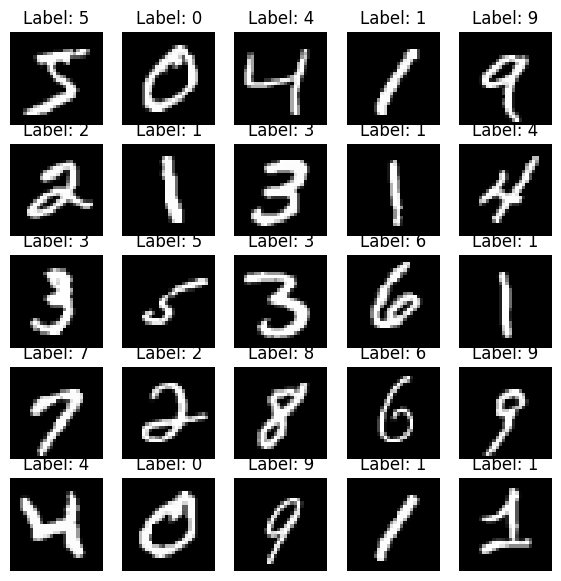

In [4]:
visualize_dataset(x_train[:25], y_train[:25], cmap="gray")

In [5]:
class GetDataset:
    def __init__(self, batch_size, datasets:tuple):
        self.ds = datasets # (X, y)
        self.batch_size = batch_size

        self.len = len(self.ds[0])

    def __iter__(self):
        rng = np.random.default_rng()
        while True:
            idx = rng.integers(low=0, high=self.len, size=self.batch_size)
            yield self.ds[0][idx], self.ds[1][idx]

In [6]:
def patchify(images:Array, patch_size:int):
    B, H, W, C = images.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    patches = nn.ops.image.extract_patches(images, size=patch_size)
    patches = patches.reshape((
            B,
            num_patches_h * num_patches_w, # N = (H*W)/P**2
            patch_size * patch_size * C, # P*2 * C
    ))
    return patches

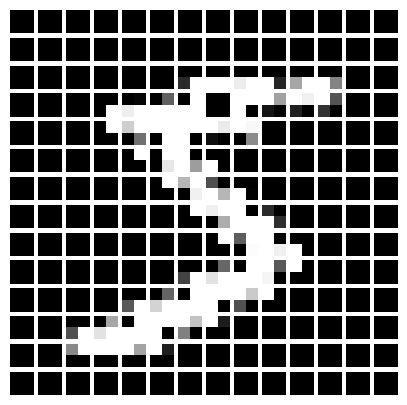

In [7]:
def visualize_patches(x:Array, patch_size:int):
    patches = patchify(x.astype(float), patch_size)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(5,5))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = jnp.reshape(patch, (patch_size, patch_size, 1))
        plt.imshow(patch_img, cmap="gray")
        plt.axis("off")

visualize_patches(x_train[:1], 2)

# Config

In [8]:
@dataclass
class config:
    # ViT specifics
    patch_size:int = 2
    H:int = H
    W:int = W
    N:int = H*W//patch_size**2  # maxlen in transformer
    assert N*patch_size**2 == H*W

    # Transformer specifics
    d_model:int = 64
    num_heads:int = 8
    num_layers:int = 5
    num_classes:int = NUM_CLASSES
    dropout_rate:float = 0
    assert d_model % 2 == 0
    assert d_model % num_heads == 0

    use_flash_att:int = USE_FLASH_ATT
    maxlen:int = N + 1
    
    # Tranining Args
    batch_size:int = 32
    num_steps:int = 7000
    eval_steps:int = 500
    checkpoint_dir:str = "weights/mnist"
    eval_freq:int = 300
    num_grad_accumalation_steps:int = 1
    patience:int = 5

    ## Optimizers Args
    beta1:float = 0.9
    beta2:float = 0.999
    weight_decay:float = 0
    clipnorm:float|None = None

    ## learning rate schedule
    min_lr:float = 1e-7
    max_lr:float = 1e-3
    decay_steps:int = num_steps
    warmup_steps:int = 100


config()

config(patch_size=2, H=28, W=28, N=196, d_model=64, num_heads=8, num_layers=5, num_classes=10, dropout_rate=0, use_flash_att=True, maxlen=197, batch_size=32, num_steps=7000, eval_steps=500, checkpoint_dir='weights/mnist', eval_freq=300, num_grad_accumalation_steps=1, patience=5, beta1=0.9, beta2=0.999, weight_decay=0, clipnorm=None, min_lr=1e-07, max_lr=0.001, decay_steps=7000, warmup_steps=100)

In [9]:
iter_ds = lambda ds: iter(GetDataset(config.batch_size, ds))

# ViT Architechture

In [10]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)

In [11]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:N
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config:config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads
        
        self.wq = nn.layers.Dense(config.d_model, use_bias=False)
        self.wk = nn.layers.Dense(config.d_model, use_bias=False)
        self.wv = nn.layers.Dense(config.d_model, use_bias=False)
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(config.d_model)
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)

        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = (
                q.reshape(shape).astype(jnp.float16), 
                k.reshape(shape).astype(jnp.float16), 
                v.reshape(shape).astype(jnp.float16)
            ) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal).astype(jnp.float32) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(-1, -2)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

In [12]:
class TransformerBlock(nn.Model):
    """```
    TransformerBlock
    Args:
        causal:bool
        config
    Inputs: 
        inputs: shape(B, T, d_model)
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config:config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in)),
            nn.layers.Activation(lambda x: nn.activations.gelu(x, approximate=True)),
            nn.layers.Dense(config.d_model),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

# Model

In [13]:
class VIT(nn.Model):
    def __init__(self, config:config, **kwargs):
        super().__init__(**kwargs)
        self.patchify = lambda x: patchify(x, config.patch_size)
        self.P = config.patch_size
        self.N = config.H*config.W//config.patch_size

        self.pos_embed = PositionalEmbedding(
            maxlen=config.maxlen,
            dim=config.d_model
        ).sinusoidal_embeddings() # (1, 1+N, d_model)

        self.proj_flattened_patches = nn.layers.Dense(
            config.d_model
        )
        self.class_emb = self.add_weight(shape=(1, config.d_model))

        self.encoder_layers = [
            TransformerBlock(causal=False, config=config)
            for _ in range(config.num_layers)
        ]
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5)
        self.mlp_head = nn.layers.Dense(config.num_classes)

    def call(self, x:Array, training:bool=True): # (B, H, W, C)
        x = self.patchify(x) # (B, N, (P**2)*C)
        x = self.proj_flattened_patches(x) # (B, N, d_model)
        # print(self.class_emb)
        x = jnp.concatenate(
            (
                jnp.broadcast_to(self.class_emb.value, (x.shape[0], 1, x.shape[-1])),
                x
            ),
            axis=1
        ) # (B, 1+N, d_model)
        x += self.pos_embed # (B, 1+N, d_model)

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training) # (B, 1+N, d_model)

        class_rep = x[:, 0, :] # (B, d_model)
        x = self.norm(class_rep) # (B, d_model)
        x = self.mlp_head(x) # (B, num_classes)
        return x # logits

In [14]:
def build_model(model:nn.Model, input_shape:tuple|None=None, input_tensor:Array|None=None):
    assert not all([input_shape is None, input_tensor is None])
    if input_tensor is None:
        input_tensor = jrand.uniform(
            jrand.PRNGKey(32344), 
            shape=input_shape,
        )
    blabla = model(
        input_tensor,
        training=True
    ); del blabla
    return model

In [15]:
model = build_model(VIT(config), input_tensor=x_train[:2])
model.summary()

Model: "vit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                         │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block               │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_1             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_2             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_3             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_4             │ ?                         │     49,792 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_10          │ ?                         │        128 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_31 (Dense)                │ ?                         │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 250,122 (977.04 KB)

 Trainable params: 250,122 (977.04 KB)

 Non-trainable params: 0 (0.00 B)

# Save weights ops

In [16]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Lr Schedule

In [17]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=config.min_lr,
    decay_steps=config.decay_steps,
    warmup_steps=config.warmup_steps,
    warmup_target=config.max_lr,
    alpha=config.min_lr/config.max_lr
)

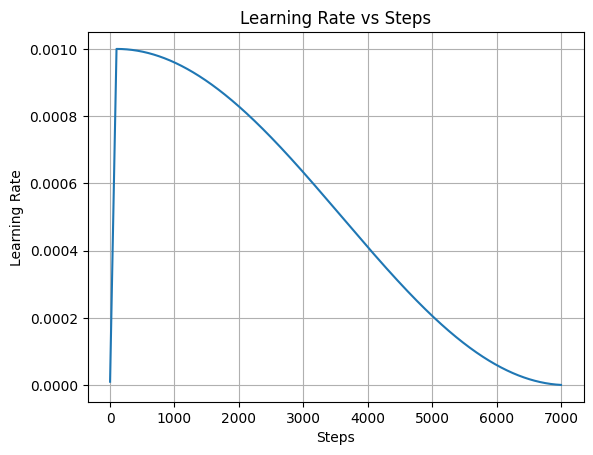

In [18]:
steps = jnp.arange(1, config.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

# Training

In [19]:
train_iterator, val_iterator = iter_ds((x_train, y_train)), iter_ds((x_val, y_val))

In [22]:
optimizer = nn.optimizers.LossScaleOptimizer(
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=config.beta1,
        beta_2=config.beta2,
        clipnorm=config.clipnorm,
        weight_decay=config.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T, num_classes), (B, T)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,  non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    scaled_loss = optimizer.scale_loss(unscaled_loss)
    return scaled_loss, (unscaled_loss, accuracy, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state

    (_, aux), scaled_grad = grad_fn(
        trainable_variables, non_trainable_variables, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_variables) = aux
    return scaled_grad, (unscaled_loss, accuracy), (trainable_variables, non_trainable_variables)

@jax.jit
def update_params(grads:list, trainable_variables:list, optimizer_variables:list):
    trainable_variables, optimizer_variables = optimizer.stateless_apply( # also handles scaled grads if LossScalerOPtimizer is used
        optimizer_variables, grads, trainable_variables
    ) # returns updated trainable_variables
    return trainable_variables, optimizer_variables

def evaluate(train_state:Sequence[list]):
    trainable_variables, non_trainable_variables = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(config.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(config.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_variables) = compute_loss(
                trainable_variables, non_trainable_variables,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [23]:
def train(return_best_states:bool):
    step = 1; wait = 0
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables

    best_step = 1
    best_train_state = (trainable_variables, non_trainable_variables)
    best_val_loss = 1e8

    t0 = time.time()
    print("Training about to start...")
    X_batch, y_batch = next(train_iterator)
    # TODO: Optimize Train Loop to reduce time per step
    while True:
        # condition to terminate
        if step > config.num_steps or wait > config.patience:
            print(f"Early Stopping at Step {step}." if wait > config.patience else "Training Terminated.")
            break
        
        # train model
        grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
        for _ in range(config.num_grad_accumalation_steps):
            grad, (loss, accuracy), (trainable_variables, non_trainable_variables) = mini_step(
                (trainable_variables, non_trainable_variables), 
                jnp.array(X_batch), jnp.array(y_batch),
                config.num_grad_accumalation_steps
            )
            grads = jax.tree_util.tree_map(
                lambda g1, g2: jnp.add(g1, g2), grads, jax.tree_util.tree_map(jnp.asarray, grad)
            ) # sum grads for grad accumation
            X_batch, y_batch = next(train_iterator)
        grad = None # save memory

        loss = loss*config.num_grad_accumalation_steps # loss from last mini-step

        trainable_variables, optimizer_variables = update_params(
            grads, trainable_variables, optimizer_variables
        )
        grads = None # save memory

        if step % config.eval_freq == 0 or step == config.num_steps:
            print("Estimating Losses...")
            mean_losses, mean_accuracies = evaluate((trainable_variables, non_trainable_variables))
            print(
                f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
            )
            
            _ = save_object(
                config.checkpoint_dir+f"|trstate{step}|weights",
                obj=best_train_state
            )
            print(f"Saved weights of step {step}.")

            if mean_losses[1] < best_val_loss:
                best_val_loss = mean_losses[1]
                best_train_state = (trainable_variables, non_trainable_variables)
                best_step = step
                wait = 0
            else:
                wait += 1

        # time
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_train_state, training_losses

    return (trainable_variables, non_trainable_variables), training_losses

In [ ]:
best_train_states, train_losses = train(return_best_states=True) # ~5mins

```python
Estimating Losses...
	| Training Loss: 0.0412 || Training Accuracy: 0.9875 || Validation Loss: 0.0556 || Validation Accuracy: 0.9837 |
Saved weights of step 7000.
| Step: 7000 || Loss: 0.0965 || Accuracy: 0.9688 || LR: 6.034003e-07 || dt: 1334.11ms |
Training Terminated.
Best Weights are from Step 7000
With an Estimated Validation Loss of 0.05562024
```

In [25]:
_ = save_object(
        config.checkpoint_dir+f"|trstate|weights",
        obj=best_train_states
    )

# Predictions

In [35]:
def seePredictions(model:nn.Model, train_states:list, xs:Array, ys:Array):
    trainable_variables, non_trainable_variables = train_states
    for x, y in zip(xs, ys): # (B, H, W, C)
        logits, non_trainable_variables = model.stateless_call(
            trainable_variables, non_trainable_variables, 
            x[None] # (1, H, W, C=1)
        ) # (1, num_classes)
        class_pred = logits.argmax(-1).squeeze()
        print("True Class:", y.tolist())
        print("Predicted Class:", class_pred.tolist())
        plt.imshow(x, cmap="gray")
        plt.show()

True Class: 7
Predicted Class: 7


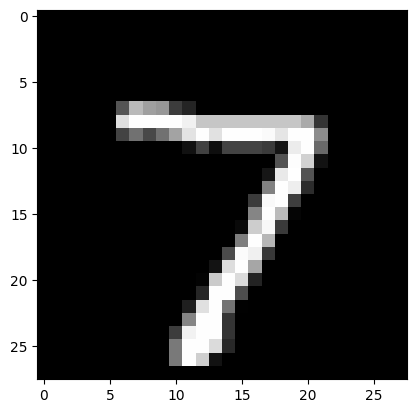

True Class: 2
Predicted Class: 2


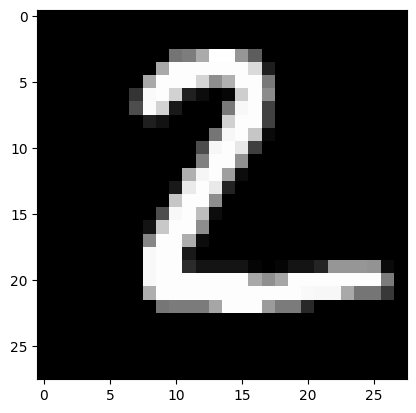

True Class: 1
Predicted Class: 1


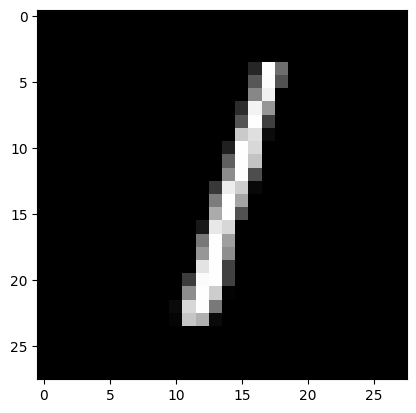

True Class: 0
Predicted Class: 0


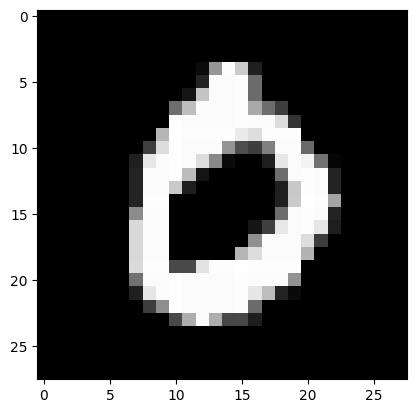

True Class: 4
Predicted Class: 4


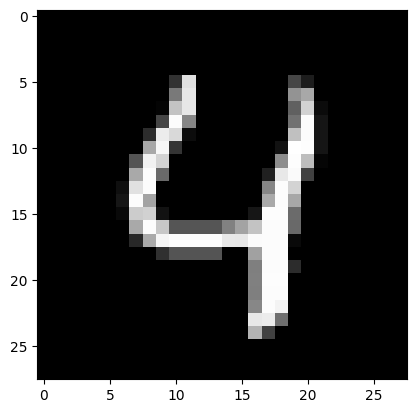

True Class: 1
Predicted Class: 1


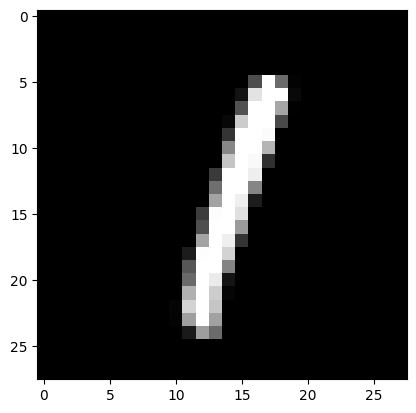

True Class: 4
Predicted Class: 4


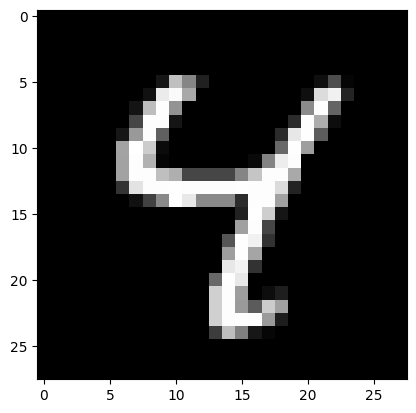

True Class: 9
Predicted Class: 9


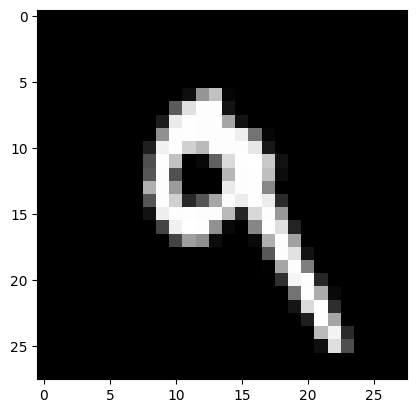

True Class: 5
Predicted Class: 5


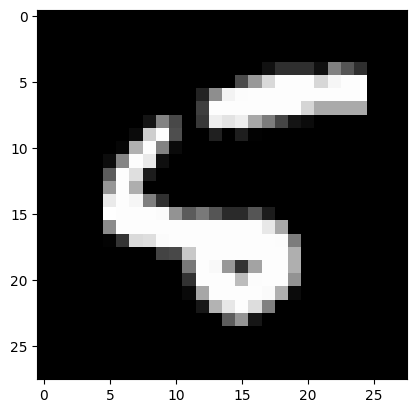

True Class: 9
Predicted Class: 9


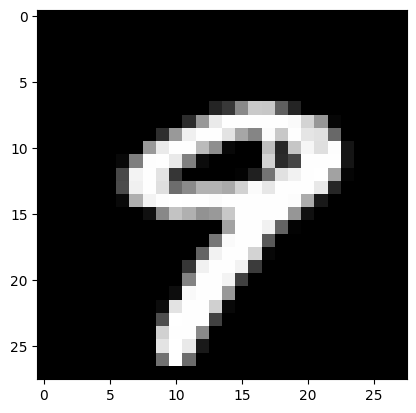

True Class: 0
Predicted Class: 0


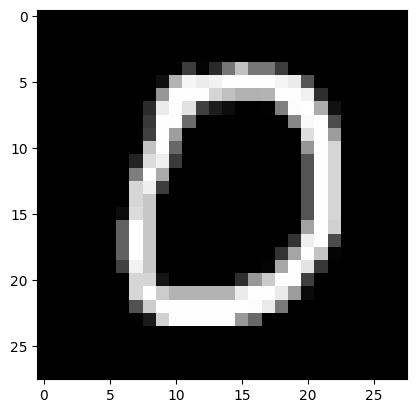

True Class: 6
Predicted Class: 6


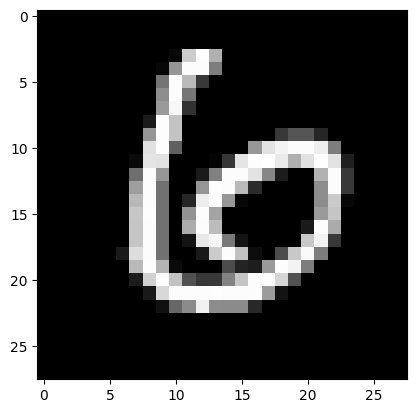

True Class: 9
Predicted Class: 9


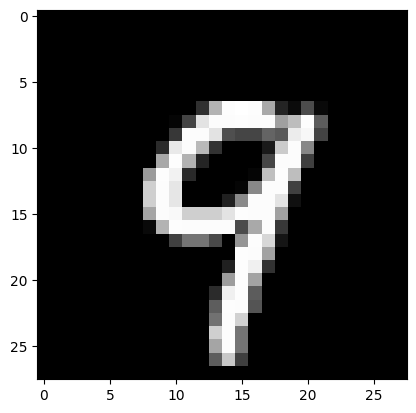

True Class: 0
Predicted Class: 0


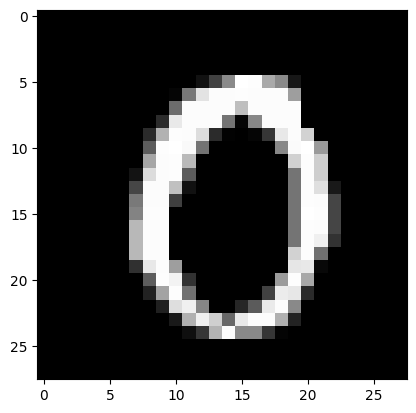

True Class: 1
Predicted Class: 1


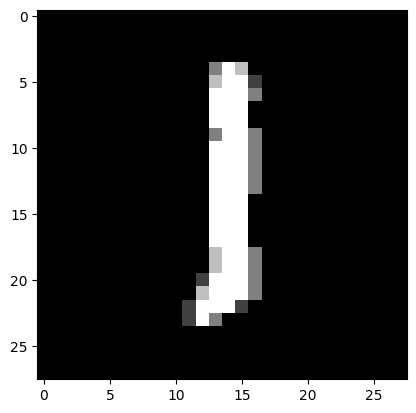

True Class: 5
Predicted Class: 5


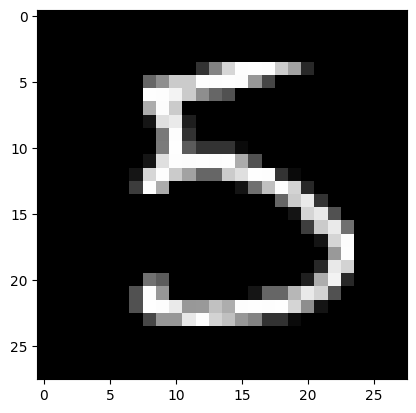

True Class: 9
Predicted Class: 9


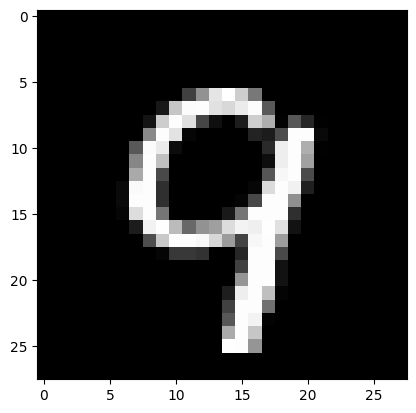

True Class: 7
Predicted Class: 7


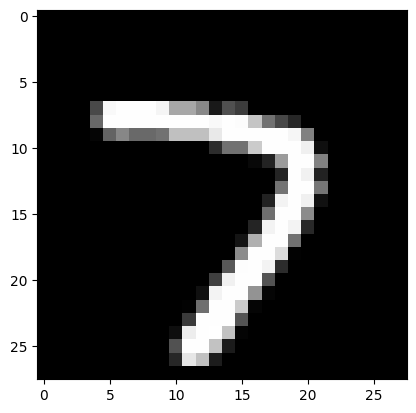

True Class: 3
Predicted Class: 3


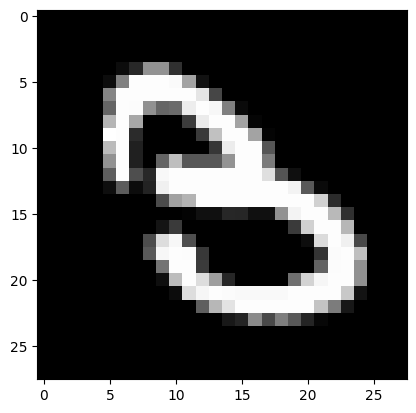

True Class: 4
Predicted Class: 4


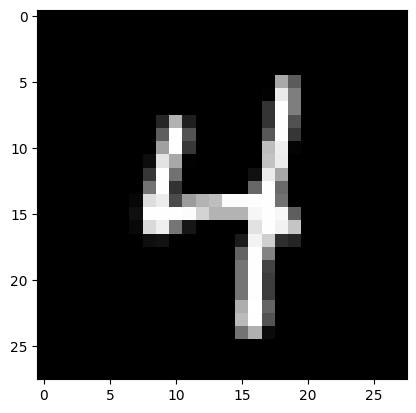

True Class: 9
Predicted Class: 9


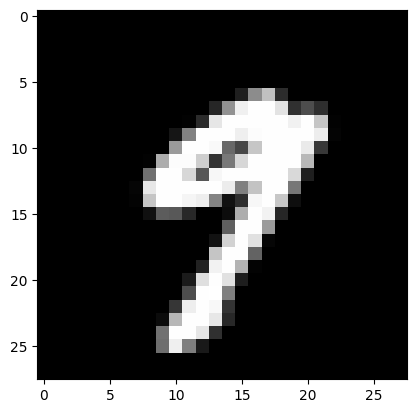

True Class: 6
Predicted Class: 6


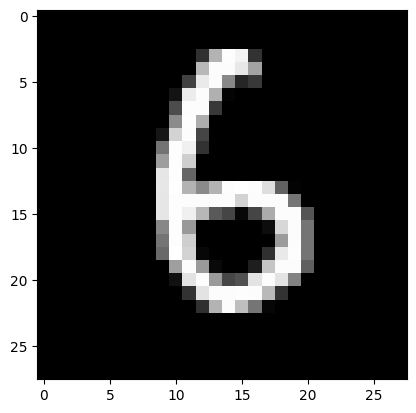

True Class: 6
Predicted Class: 6


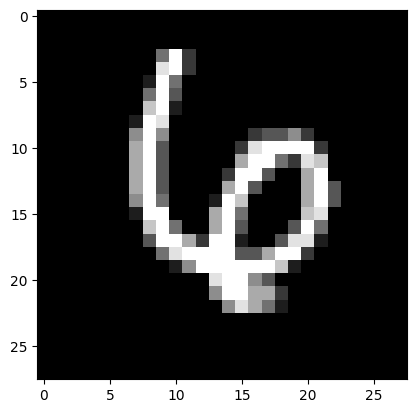

True Class: 5
Predicted Class: 5


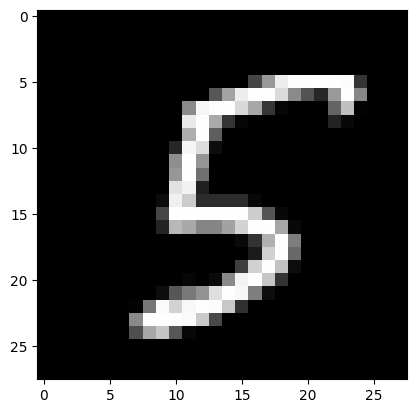

True Class: 4
Predicted Class: 4


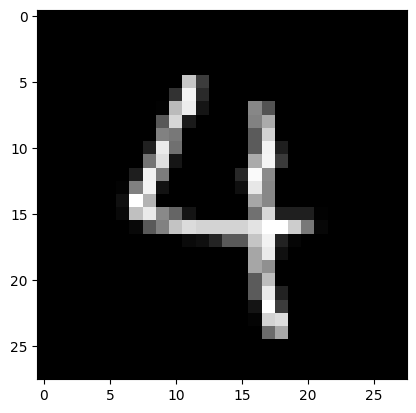

In [36]:
seePredictions(model, best_train_states, x_val[:25], y_val[:25])

```python
# Whats wrong in this?
def my_patchify(x, P): # (B, H, W, C)
    N = np.prod(x.shape[1:-1])//P**2
    assert N*P**2 == H*W, "<<-- should be True for patching"
    return x.reshape((-1, N, (P**2)*x.shape[-1]))
```